## Multi-class Classification Experiments

#### Predicting 'namespace'

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
import seaborn as sns

### Parse the Dataset

In [3]:
def parse_obo_file(file_path):
    data = []
    current_term = {}
    in_term_block = False
    
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line == '[Term]':  #starting a new term block
                if current_term:
                    data.append(current_term)
                current_term = {}
                in_term_block = True
            elif line == '':
                in_term_block = False  #end of a term block
            elif in_term_block:
                if ': ' in line:
                    key, value = line.split(': ', 1)
                    if key in current_term:  #handling multiple lines of the same key
                        if isinstance(current_term[key], list):
                            current_term[key].append(value)
                        else:
                            current_term[key] = [current_term[key], value]
                    else:
                        current_term[key] = value

    
    if current_term: #add the last term if file does not end with a newline
        data.append(current_term)

    return pd.DataFrame(data)

df = parse_obo_file(go_file)


In [4]:
#updating 'def' column to 'definition'
df = df.rename(columns={'def': 'definition'}) 

In [5]:
df.head(4)

,id,name,namespace,definition,synonym,is_a,alt_id,comment,is_obsolete,replaced_by,consider,xref,subset,relationship
0,GO:0000001,mitochondrion inheritance,biological_process,"""The distribution of mitochondria, including t...","""mitochondrial inheritance"" EXACT []","[GO:0048308 ! organelle inheritance, GO:004831...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GO:0000002,mitochondrial genome maintenance,biological_process,"""The maintenance of the structure and integrit...",NaN,GO:0007005 ! mitochondrion organization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GO:0000003,obsolete reproduction,biological_process,"""OBSOLETE. The production of new individuals t...","""reproductive physiological process"" EXACT []",NaN,"[GO:0019952, GO:0050876]",The reason for obsoletion is that this term is...,true,GO:0022414,NaN,NaN,NaN,NaN
3,GO:0000005,obsolete ribosomal chaperone activity,molecular_function,"""OBSOLETE. Assists in the correct assembly of ...","""ribosomal chaperone activity"" EXACT []",NaN,NaN,This term was made obsolete because it refers ...,true,NaN,"[GO:0042254, GO:0044183, GO:0051082]",NaN,NaN,NaN


In [6]:
df['id'].nunique()

47856

In [7]:
df.namespace.nunique()

3

In [8]:
df.namespace.value_counts()


namespace
biological_process    30723
molecular_function    12614
cellular_component     4519
Name: count, dtype: int64

In [9]:
df["namespace"].unique()

array(['biological_process', 'molecular_function', 'cellular_component'],
      dtype=object)

In [10]:
df[df.is_obsolete == 'true']

,id,name,namespace,definition,synonym,is_a,alt_id,comment,is_obsolete,replaced_by,consider,xref,subset,relationship
2,GO:0000003,obsolete reproduction,biological_process,"""OBSOLETE. The production of new individuals t...","""reproductive physiological process"" EXACT []",NaN,"[GO:0019952, GO:0050876]",The reason for obsoletion is that this term is...,true,GO:0022414,NaN,NaN,NaN,NaN
3,GO:0000005,obsolete ribosomal chaperone activity,molecular_function,"""OBSOLETE. Assists in the correct assembly of ...","""ribosomal chaperone activity"" EXACT []",NaN,NaN,This term was made obsolete because it refers ...,true,NaN,"[GO:0042254, GO:0044183, GO:0051082]",NaN,NaN,NaN
6,GO:0000008,obsolete thioredoxin,molecular_function,"""OBSOLETE. A small disulfide-containing redox ...","""thioredoxin"" EXACT []",NaN,GO:0000013,This term was made obsolete because it represe...,true,NaN,"[GO:0003756, GO:0015036]",NaN,NaN,NaN
17,GO:0000020,obsolete negative regulation of recombination ...,biological_process,"""OBSOLETE. Any process that stops, prevents, o...","""negative regulation of recombination within r...",NaN,NaN,This term was made obsolete because it describ...,true,NaN,GO:0045950,NaN,NaN,NaN
33,GO:0000039,obsolete plasma membrane long-chain fatty acid...,molecular_function,"""OBSOLETE. (Was not defined before being made ...","""plasma membrane long-chain fatty acid transpo...",NaN,NaN,This term was made obsolete because it describ...,true,NaN,"[GO:0005324, GO:0005886]",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47792,GO:2001254,obsolete negative regulation of histone H3-K36...,biological_process,"""OBSOLETE. Any process that stops, prevents or...",NaN,NaN,NaN,This term was obsoleted because it represents ...,true,NaN,GO:0006338,NaN,NaN,NaN
47793,GO:2001255,obsolete positive regulation of histone H3-K36...,biological_process,"""OBSOLETE. Any process that activates or incre...",NaN,NaN,NaN,This term was obsoleted because it represents ...,true,NaN,GO:0140673,NaN,NaN,NaN
47811,GO:2001273,obsolete regulation of glucose import in respo...,biological_process,"""OBSOLETE. Any process that modulates the freq...","""regulation of cellular glucose import in resp...",NaN,NaN,This term was obsoleted because it represents ...,true,NaN,NaN,NaN,NaN,NaN
47812,GO:2001274,obsolete negative regulation of glucose import...,biological_process,"""OBSOLETE. Any process that stops, prevents or...","""negative regulation of cellular glucose impor...",NaN,NaN,NaN,true,NaN,NaN,NaN,NaN,NaN


In [11]:
df[df.is_obsolete.isna() == True]

,id,name,namespace,definition,synonym,is_a,alt_id,comment,is_obsolete,replaced_by,consider,xref,subset,relationship
0,GO:0000001,mitochondrion inheritance,biological_process,"""The distribution of mitochondria, including t...","""mitochondrial inheritance"" EXACT []","[GO:0048308 ! organelle inheritance, GO:004831...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GO:0000002,mitochondrial genome maintenance,biological_process,"""The maintenance of the structure and integrit...",NaN,GO:0007005 ! mitochondrion organization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,GO:0000006,high-affinity zinc transmembrane transporter a...,molecular_function,"""Enables the transfer of zinc ions (Zn2+) from...","[""high affinity zinc uptake transmembrane tran...",GO:0005385 ! zinc ion transmembrane transporte...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,GO:0000007,low-affinity zinc ion transmembrane transporte...,molecular_function,"""Enables the transfer of a solute or solutes f...",NaN,GO:0005385 ! zinc ion transmembrane transporte...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,GO:0000009,"alpha-1,6-mannosyltransferase activity",molecular_function,"""Catalysis of the transfer of a mannose residu...","""1,6-alpha-mannosyltransferase activity"" EXACT []",GO:0000030 ! mannosyltransferase activity,NaN,NaN,NaN,NaN,NaN,"Reactome:R-HSA-449718 ""Addition of a third man...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47851,GO:2001313,UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...,biological_process,"""The chemical reactions and pathways involving...","""UDP-4-deoxy-4-formamido-beta-L-arabinopyranos...","[GO:0006040 ! amino sugar metabolic process, G...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47852,GO:2001314,UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...,biological_process,"""The chemical reactions and pathways resulting...","[""UDP-4-deoxy-4-formamido-beta-L-arabinopyrano...",[GO:0009227 ! nucleotide-sugar catabolic proce...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47853,GO:2001315,UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...,biological_process,"""The chemical reactions and pathways resulting...","[""UDP-4-deoxy-4-formamido-beta-L-arabinopyrano...",[GO:0009226 ! nucleotide-sugar biosynthetic pr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47854,GO:2001316,kojic acid metabolic process,biological_process,"""The chemical reactions and pathways involving...","[""5-hydroxy-2-(hydroxymethyl)-4H-pyran-4-one m...",[GO:0034308 ! primary alcohol metabolic proces...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Preprocessing

### 1. Remove obsolete terms

In [12]:
df.is_obsolete.value_counts()

is_obsolete
true    5653
Name: count, dtype: int64

In [13]:
df = df[df.is_obsolete.isna() == True]

In [14]:
df.namespace.value_counts()

namespace
biological_process    27014
molecular_function    11132
cellular_component     4057
Name: count, dtype: int64

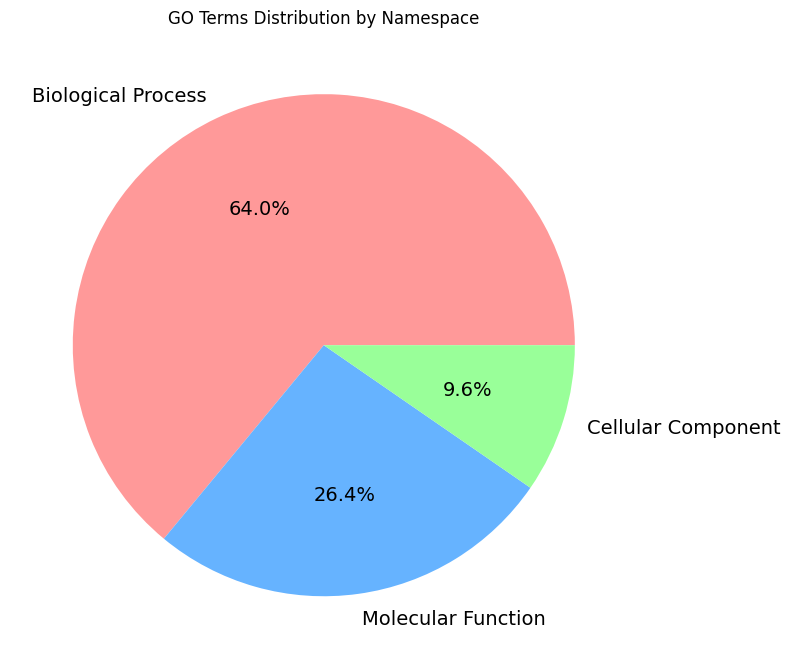

In [38]:
namespace_counts = df.namespace.value_counts().copy()
labels = ['Biological Process', 'Molecular Function', 'Cellular Component']

plt.figure(figsize=(8, 8))
plt.pie(namespace_counts, labels=labels, autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'], textprops={'fontsize': 14})
plt.title('GO Terms Distribution by Namespace')
plt.tight_layout()

plt.savefig('../images/piechart.png')
plt.show()

### 2. Remove unnecessary columns

In [16]:
df = df[['id','namespace','definition']]

### 3. Remove the content in [] at the end of definitions

In [17]:
df['definition'][100]

'"Any process that stops, prevents, or reduces the frequency, rate or extent of transcription mediated by RNA polymerase II." [GOC:go_curators, GOC:txnOH]'

In [18]:
df['definition'].str.replace(r' \[.*?\]$', '', regex=True)[100]

'"Any process that stops, prevents, or reduces the frequency, rate or extent of transcription mediated by RNA polymerase II."'

In [19]:
df['definition'] = df['definition'].str.replace(r' \[.*?\]$', '', regex=True)

### 4. Convert the defintions into feature vectors 
The stop words will be removed in process.

Note that when transforming the definitions to feature vectors, there are 38093 columns created which may create issues like overfitting, curse of dimensionality, etc. 

To handle this we will exclude some words that do not appear in some % of definitions. 

We will test for words that do not appear in 1% of definitions and 5% of definitions.
For this experiment, we create 2 separate datasets.

(Where one dataset excludes the words that do not appear in 1% of the defintions and the other dataset that excludes words that do not appear in 5 % of the definitions)

#### a. Dataset that excludes words that do not appear in 1% of definitions

This gives 165 columns.

In [20]:
vectorizer1 = CountVectorizer(stop_words='english', min_df=0.01)
X1 = vectorizer1.fit_transform(df['definition'])
dense_X1 = X1.toarray()
#creating a df with feature names as columns
X1_df = pd.DataFrame(dense_X1, columns=vectorizer1.get_feature_names_out())

In [21]:
X1_df

,acetyl,acid,acids,activates,activation,activity,adenosyl,adp,agent,alpha,...,time,tissue,transcription,transfer,transport,transported,transporter,type,udp,vesicle
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
42199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
42200,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
42201,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### b. Dataset that excludes words that do not appear in 5% of definitions

This gives 27 columns.

In [22]:
vectorizer5 = CountVectorizer(stop_words='english', min_df=0.05)
X5 = vectorizer5.fit_transform(df['definition'])
dense_X5 = X5.toarray()
#creating a df with feature names as columns
X5_df = pd.DataFrame(dense_X5, columns=vectorizer5.get_feature_names_out())

In [23]:
X5_df.head(3)

,acid,activates,activity,binding,catalysis,cell,cells,chemical,complex,extent,...,pathways,prevents,process,protein,rate,reaction,reactions,reduces,resulting,stops
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Label dataframe

In [24]:
y = df['namespace']

### 4. Normalising both datasets


In [25]:
scaler = StandardScaler()

#### a. Dataset that excludes words that do not appear in 1% of definitions

In [26]:
dense_X1 = X1.toarray()
X1_normalized = scaler.fit_transform(dense_X1)
X1_normalized = pd.DataFrame(X1_normalized, columns=vectorizer1.get_feature_names_out())

In [27]:
X1_normalized.head()

,acetyl,acid,acids,activates,activation,activity,adenosyl,adp,agent,alpha,...,time,tissue,transcription,transfer,transport,transported,transporter,type,udp,vesicle
0,-0.100664,-0.214694,-0.09007,-0.26092,-0.102914,-0.285862,-0.098302,-0.116371,-0.110491,-0.143652,...,-0.162311,-0.106314,-0.110159,-0.185535,-0.121534,-0.111373,-0.120197,-0.126945,-0.104698,-0.094248
1,-0.100664,-0.214694,-0.09007,-0.26092,-0.102914,-0.285862,-0.098302,-0.116371,-0.110491,-0.143652,...,-0.162311,-0.106314,-0.110159,-0.185535,-0.121534,-0.111373,-0.120197,-0.126945,-0.104698,-0.094248
2,-0.100664,-0.214694,-0.09007,-0.26092,-0.102914,-0.285862,-0.098302,-0.116371,-0.110491,-0.143652,...,-0.162311,-0.106314,-0.110159,5.218277,5.387711,-0.111373,7.983116,-0.126945,-0.104698,-0.094248
3,-0.100664,-0.214694,-0.09007,-0.26092,-0.102914,-0.285862,-0.098302,-0.116371,-0.110491,-0.143652,...,-0.162311,-0.106314,-0.110159,5.218277,5.387711,-0.111373,7.983116,-0.126945,-0.104698,-0.094248
4,-0.100664,-0.214694,-0.09007,-0.26092,-0.102914,-0.285862,-0.098302,-0.116371,-0.110491,3.167401,...,-0.162311,-0.106314,-0.110159,5.218277,-0.121534,-0.111373,-0.120197,-0.126945,-0.104698,-0.094248


#### b. Dataset that excludes words that do not appear in 5% of definitions

In [28]:
dense_X5 = X5.toarray()
X5_normalized = scaler.fit_transform(dense_X5)
X5_normalized = pd.DataFrame(X5_normalized, columns=vectorizer5.get_feature_names_out())

In [29]:
X5_normalized.head()

,acid,activates,activity,binding,catalysis,cell,cells,chemical,complex,extent,...,pathways,prevents,process,protein,rate,reaction,reactions,reduces,resulting,stops
0,-0.214694,-0.26092,-0.285862,-0.25055,-0.463185,-0.424066,2.595929,-0.348916,-0.242521,-0.522805,...,-0.345781,-0.263808,-0.777484,-0.295469,-0.529708,-0.436470,-0.348313,-0.26891,-0.300775,-0.2635
1,-0.214694,-0.26092,-0.285862,-0.25055,-0.463185,-0.424066,-0.218105,-0.348916,-0.242521,-0.522805,...,-0.345781,-0.263808,-0.777484,-0.295469,-0.529708,-0.436470,-0.348313,-0.26891,-0.300775,-0.2635
2,-0.214694,-0.26092,-0.285862,-0.25055,-0.463185,-0.424066,-0.218105,-0.348916,-0.242521,-0.522805,...,-0.345781,-0.263808,-0.777484,-0.295469,-0.529708,-0.436470,-0.348313,-0.26891,-0.300775,-0.2635
3,-0.214694,-0.26092,-0.285862,-0.25055,-0.463185,-0.424066,-0.218105,-0.348916,-0.242521,-0.522805,...,-0.345781,-0.263808,-0.777484,-0.295469,-0.529708,2.114473,-0.348313,-0.26891,-0.300775,-0.2635
4,-0.214694,-0.26092,-0.285862,-0.25055,2.130738,-0.424066,-0.218105,-0.348916,-0.242521,-0.522805,...,-0.345781,-0.263808,-0.777484,-0.295469,-0.529708,-0.436470,-0.348313,-0.26891,-0.300775,-0.2635


## K-Nearest Neighbors

### Non-Normalised Dataset

### 1. KKN using the dataset that excludes the words that appear in less than 1% of the defintions

- The stop words have been removed while transforming the definitions to feature vectors

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X1_df, y, test_size=0.2, random_state=42)

In [31]:
acc = []
for i in range(1,20):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(accuracy_score(y_test, yhat))

Maximum accuracy: 0.954744698495439 at K = 5


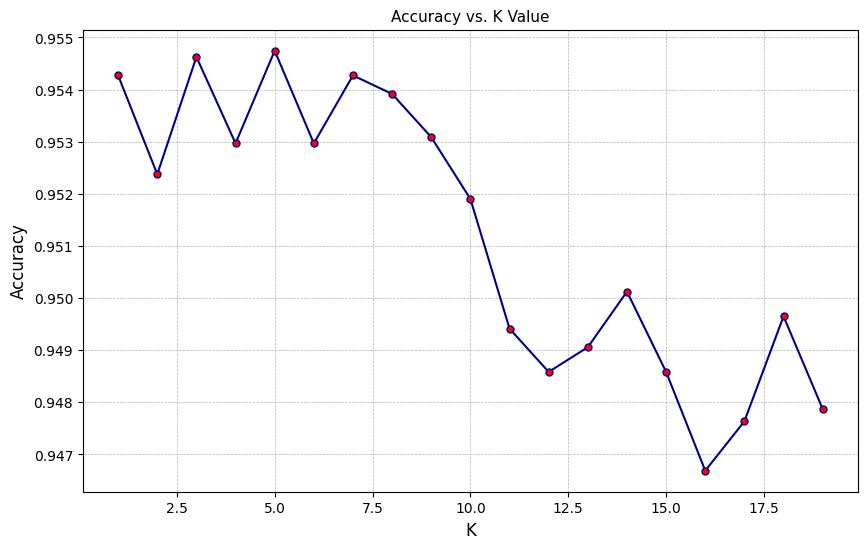

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(range(1,20), acc, color='darkblue', linestyle='-', marker='o', markerfacecolor='red', markersize=5)
plt.title('Accuracy vs. K Value', fontsize=11)
plt.xlabel('K', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
print("Maximum accuracy:",max(acc),"at K =",acc.index(max(acc))+1)
plt.savefig('../images/KNN1.png')
plt.show()

Max accuracy for K = 5

In [33]:
neigh = KNeighborsClassifier(n_neighbors = 5).fit(X_train,y_train)
y_pred = neigh.predict(X_test)

In [40]:
confusion_matrix(y_test,y_pred)

array([[5256,   91,   25],
       [ 170,  629,   21],
       [  55,   20, 2174]])

In [41]:
accuracy_score(y_test, y_pred)

0.954744698495439

### 2. KKN using the dataset that excludes the words that appear in less than 5% of the defintions


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X5_df, y, test_size=0.2, random_state=42)

In [43]:
acc = []
for i in range(1,20):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(accuracy_score(y_test, yhat))

Maximum accuracy: 0.9261935789598389 at K = 6


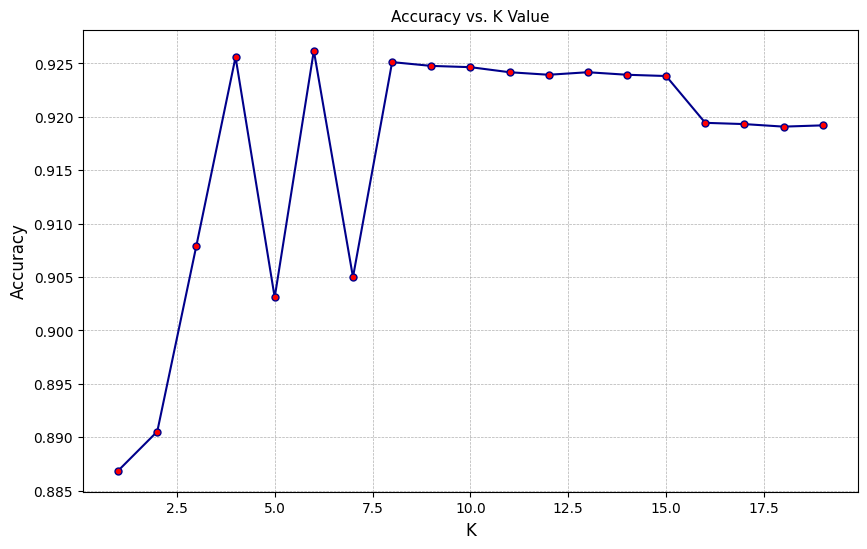

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(range(1,20), acc, color='darkblue', linestyle='-', marker='o', markerfacecolor='red', markersize=5)
plt.title('Accuracy vs. K Value', fontsize=11)
plt.xlabel('K', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
print("Maximum accuracy:",max(acc),"at K =",acc.index(max(acc))+1)
#plt.savefig('KNN2')
plt.show()

Max accuracy for K = 6

In [45]:
neigh = KNeighborsClassifier(n_neighbors = 6).fit(X_train,y_train)
y_pred = neigh.predict(X_test)

In [46]:
accuracy_score(y_test, y_pred)

0.9261935789598389

In [47]:
confusion_matrix(y_test,y_pred)

array([[5262,   75,   35],
       [ 307,  497,   16],
       [  80,  110, 2059]])

### Normalized data

### 1. KKN using the dataset that excludes the words that do not appear in 1% of the defintions


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X1_normalized, y, test_size=0.2, random_state=42)

In [49]:
acc = []
for i in range(1,20):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(accuracy_score(y_test, yhat))

Maximum accuracy: 0.9436085771827982 at K = 1


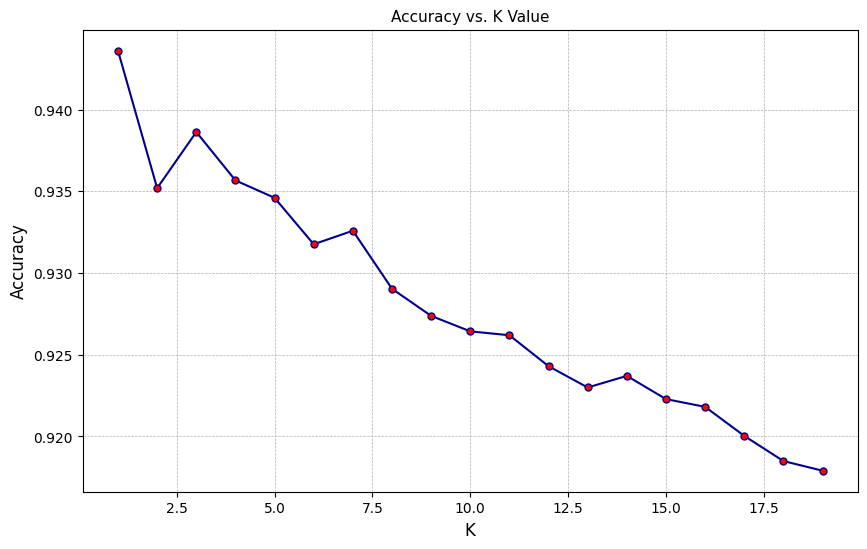

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(range(1,20), acc, color='darkblue', linestyle='-', marker='o', markerfacecolor='red', markersize=5)
plt.title('Accuracy vs. K Value', fontsize=11)
plt.xlabel('K', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
print("Maximum accuracy:",max(acc),"at K =",acc.index(max(acc))+1)
#plt.savefig('KNN3')
plt.show()

Max accuracy for K = 1

In [51]:
neigh = KNeighborsClassifier(n_neighbors = 1).fit(X_train,y_train)
y_pred = neigh.predict(X_test)

In [52]:
accuracy_score(y_test,y_pred)

0.9436085771827982

In [53]:
confusion_matrix(y_test,y_pred)

array([[5199,  113,   60],
       [ 168,  616,   36],
       [  68,   31, 2150]])

### 2. KKN using the dataset that excludes the words that do not appear in 5% of the defintions


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X5_normalized, y, test_size=0.2, random_state=42)

In [55]:
acc = []
for i in range(1,20):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(accuracy_score(y_test, yhat))

Maximum accuracy: 0.9245350077005094 at K = 16


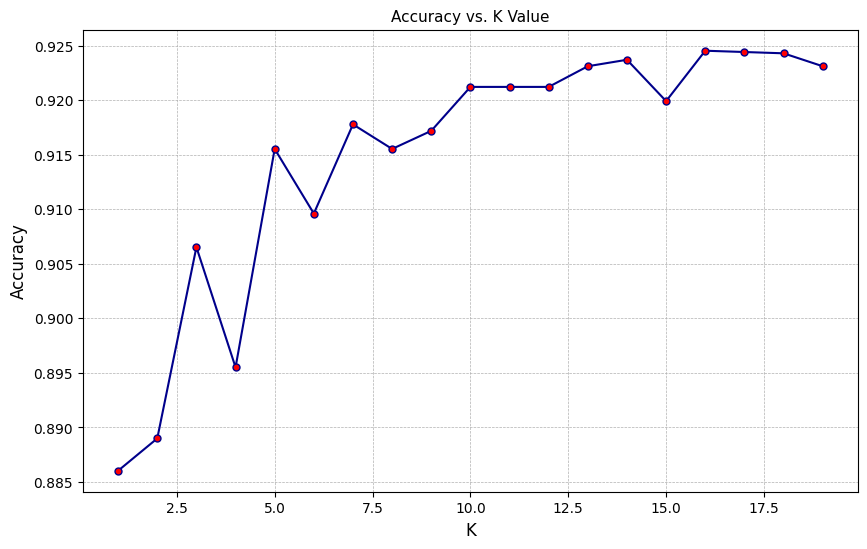

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(range(1,20), acc, color='darkblue', linestyle='-', marker='o', markerfacecolor='red', markersize=5)
plt.title('Accuracy vs. K Value', fontsize=11)
plt.xlabel('K', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
print("Maximum accuracy:",max(acc),"at K =",acc.index(max(acc))+1)
#plt.savefig('KNN4')
plt.show()

Max accuracy for K = 16

In [57]:
neigh = KNeighborsClassifier(n_neighbors = 16).fit(X_train,y_train)
y_pred = neigh.predict(X_test)

In [58]:
accuracy_score(y_test,y_pred)

0.9245350077005094

In [59]:
print(confusion_matrix(y_test,y_pred))

[[5234   73   65]
 [ 298  439   83]
 [  88   30 2131]]


### KNN Results
- max accuracy with KNN ignoring words that appear in less than 1% of definitions: 0.954744698495439 (K = 5)
- max accuracy with KNN ignoring words that appear in less than 5% of definitions : 0.9261935789598389 (K = 6)

- max accuracy with KNN on Normalized data ignoring words appear in less than 1% of definitions: 0.9436085771827982 (K = 1)
- max accuracy with KNN on Normalized data ignoring words appear in less than 5% of definitions: 0.9245350077005094 (K = 16)


### Downsampling (To be used for GridSearch Optimization)

#### a. Dataset that excludes words that do not appear in 1% of definitions

In [34]:
len(X1_df)

42203

In [35]:
X1_df.head()

,acetyl,acid,acids,activates,activation,activity,adenosyl,adp,agent,alpha,...,time,tissue,transcription,transfer,transport,transported,transporter,type,udp,vesicle
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [36]:
X1_df_dup = X1_df.copy()
X1_df_dup['namespace'] = df['namespace']

In [37]:
X1_df_dup['namespace'].value_counts()

namespace
biological_process    22624
molecular_function    10891
cellular_component     3633
Name: count, dtype: int64

In [38]:
X1_biological_process_df = X1_df_dup[X1_df_dup['namespace'] == 'biological_process']
X1_molecular_function_df = X1_df_dup[X1_df_dup['namespace'] == 'molecular_function']
X1_cellular_component_df = X1_df_dup[X1_df_dup['namespace'] == 'cellular_component']

In [39]:
X1_biological_process_downsampled = resample(X1_biological_process_df, replace = False, n_samples = 2500, random_state=42)
len(X1_biological_process_downsampled)

2500

In [40]:
X1_molecular_function_downsampled = resample(X1_molecular_function_df, replace = False, n_samples = 2500, random_state=42)
len(X1_molecular_function_downsampled)

2500

In [41]:
X1_cellular_component_downsampled = resample(X1_cellular_component_df, replace = False, n_samples = 2500, random_state=42)
len(X1_cellular_component_downsampled)

2500

In [42]:
X1_df_downsampled = pd.concat([X1_biological_process_downsampled,X1_molecular_function_downsampled,X1_cellular_component_downsampled])
len(X1_df_downsampled)

7500

##### Downsampled Labels for dataset exlcuding words from 1% definitions

In [43]:
X1_downsampled_y = X1_df_downsampled['namespace']

##### Downsampled features for dataset exlcuding words from 1% definitions

In [44]:
X1_df_downsampled = X1_df_downsampled.drop('namespace', axis = 1)

#### b. Dataset that excludes words that do not appear in 5% of definitions

This gives 27 columns


In [45]:
X5_df_dup = X5_df.copy()
X5_df_dup['namespace'] = df['namespace']

In [46]:
X5_df_dup['namespace'].value_counts()

namespace
biological_process    22624
molecular_function    10891
cellular_component     3633
Name: count, dtype: int64

In [47]:
X5_biological_process_df = X5_df_dup[X5_df_dup['namespace'] == 'biological_process']
X5_molecular_function_df = X5_df_dup[X5_df_dup['namespace'] == 'molecular_function']
X5_cellular_component_df = X5_df_dup[X5_df_dup['namespace'] == 'cellular_component']

In [48]:
X5_biological_process_downsampled = resample(X5_biological_process_df, replace = False, n_samples = 2500, random_state=42)
len(X5_biological_process_downsampled)

2500

In [49]:
X5_molecular_function_downsampled = resample(X5_molecular_function_df, replace = False, n_samples = 2500, random_state=42)
len(X5_molecular_function_downsampled)

2500

In [50]:
X5_cellular_component_downsampled = resample(X5_cellular_component_df, replace = False, n_samples = 2500, random_state=42)
len(X5_cellular_component_downsampled)

2500

In [51]:
X5_df_downsampled = pd.concat([X5_biological_process_downsampled,X5_molecular_function_downsampled,X5_cellular_component_downsampled])
len(X5_df_downsampled)

7500

##### Downsampled Labels for dataset exlcuding words from 5% definitions

In [52]:
X5_downsampled_y = X5_df_downsampled['namespace']

##### Downsampled features for dataset exlcuding words from 5% definitions

In [53]:
X5_df_downsampled = X5_df_downsampled.drop('namespace', axis = 1)

#### Normalised Downsampled Data

In [54]:
scaler = StandardScaler()

1. Ignoring words that do not appear in 1% of definitions

In [55]:
X1_normalized_downsampled = scaler.fit_transform(X1_df_downsampled)
X1_normalized_downsampled = pd.DataFrame(X1_normalized_downsampled, columns = X1_df_downsampled.columns)

In [56]:
X1_normalized_downsampled

,acetyl,acid,acids,activates,activation,activity,adenosyl,adp,agent,alpha,...,time,tissue,transcription,transfer,transport,transported,transporter,type,udp,vesicle
0,-0.095864,-0.23326,-0.084827,-0.264677,-0.094073,-0.288427,-0.097106,-0.116154,-0.107067,-0.144835,...,-0.151382,-0.097454,-0.106911,-0.176897,-0.13192,-0.111466,-0.119907,-0.123254,-0.107511,-0.089467
1,-0.095864,-0.23326,-0.084827,-0.264677,-0.094073,-0.288427,-0.097106,-0.116154,-0.107067,-0.144835,...,-0.151382,-0.097454,-0.106911,-0.176897,-0.13192,-0.111466,-0.119907,5.129053,-0.107511,-0.089467
2,-0.095864,-0.23326,-0.084827,-0.264677,9.570916,-0.288427,-0.097106,-0.116154,-0.107067,-0.144835,...,-0.151382,-0.097454,4.582183,-0.176897,-0.13192,-0.111466,-0.119907,-0.123254,-0.107511,-0.089467
3,-0.095864,-0.23326,-0.084827,-0.264677,-0.094073,-0.288427,-0.097106,-0.116154,-0.107067,-0.144835,...,6.527234,-0.097454,-0.106911,-0.176897,-0.13192,-0.111466,-0.119907,-0.123254,-0.107511,-0.089467
4,-0.095864,-0.23326,-0.084827,-0.264677,-0.094073,-0.288427,-0.097106,-0.116154,-0.107067,-0.144835,...,-0.151382,-0.097454,-0.106911,-0.176897,-0.13192,-0.111466,-0.119907,-0.123254,-0.107511,-0.089467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,-0.095864,-0.23326,-0.084827,-0.264677,-0.094073,-0.288427,-0.097106,-0.116154,-0.107067,-0.144835,...,-0.151382,-0.097454,-0.106911,-0.176897,-0.13192,-0.111466,-0.119907,-0.123254,-0.107511,-0.089467
7496,-0.095864,-0.23326,-0.084827,-0.264677,-0.094073,-0.288427,-0.097106,-0.116154,-0.107067,-0.144835,...,-0.151382,-0.097454,-0.106911,-0.176897,-0.13192,-0.111466,-0.119907,-0.123254,-0.107511,-0.089467
7497,-0.095864,-0.23326,-0.084827,-0.264677,-0.094073,-0.288427,-0.097106,-0.116154,-0.107067,-0.144835,...,-0.151382,-0.097454,-0.106911,-0.176897,-0.13192,-0.111466,-0.119907,-0.123254,10.034992,-0.089467
7498,-0.095864,-0.23326,-0.084827,-0.264677,-0.094073,-0.288427,-0.097106,-0.116154,-0.107067,-0.144835,...,-0.151382,-0.097454,-0.106911,-0.176897,-0.13192,-0.111466,-0.119907,-0.123254,-0.107511,-0.089467


2. Ignoring words that do not appear in 5% of definitions

In [57]:
X5_normalized_downsampled = scaler.fit_transform(X5_df_downsampled)
X5_normalized_downsampled = pd.DataFrame(X5_normalized_downsampled, columns = X5_df_downsampled.columns)

In [58]:
X5_normalized_downsampled

,acid,activates,activity,binding,catalysis,cell,cells,chemical,complex,extent,...,pathways,prevents,process,protein,rate,reaction,reactions,reduces,resulting,stops
0,-0.23326,-0.264677,-0.288427,-0.251929,-0.454082,1.172848,-0.215757,-0.387979,-0.231462,1.913448,...,-0.383825,-0.265539,0.955270,-0.291795,1.897690,-0.426185,-0.385338,-0.271248,-0.331608,-0.263519
1,-0.23326,-0.264677,-0.288427,-0.251929,-0.454082,-0.412939,-0.215757,-0.387979,5.193431,-0.521790,...,-0.383825,-0.265539,-0.753417,2.206453,-0.526131,-0.426185,-0.385338,-0.271248,-0.331608,-0.263519
2,-0.23326,-0.264677,-0.288427,-0.251929,-0.454082,-0.412939,-0.215757,-0.387979,-0.231462,-0.521790,...,-0.383825,-0.265539,-0.753417,-0.291795,-0.526131,-0.426185,-0.385338,-0.271248,-0.331608,-0.263519
3,-0.23326,-0.264677,-0.288427,-0.251929,-0.454082,-0.412939,11.467850,-0.387979,-0.231462,-0.521790,...,-0.383825,-0.265539,-0.753417,-0.291795,-0.526131,-0.426185,-0.385338,-0.271248,-0.331608,-0.263519
4,-0.23326,-0.264677,-0.288427,3.580666,-0.454082,-0.412939,-0.215757,-0.387979,-0.231462,-0.521790,...,-0.383825,-0.265539,-0.753417,-0.291795,-0.526131,-0.426185,-0.385338,-0.271248,-0.331608,-0.263519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,-0.23326,-0.264677,-0.288427,-0.251929,-0.454082,-0.412939,-0.215757,-0.387979,-0.231462,-0.521790,...,-0.383825,-0.265539,2.663958,-0.291795,-0.526131,-0.426185,-0.385338,-0.271248,-0.331608,-0.263519
7496,-0.23326,-0.264677,-0.288427,-0.251929,2.181843,-0.412939,-0.215757,-0.387979,-0.231462,-0.521790,...,-0.383825,-0.265539,-0.753417,-0.291795,-0.526131,-0.426185,-0.385338,-0.271248,-0.331608,-0.263519
7497,-0.23326,-0.264677,-0.288427,-0.251929,2.181843,-0.412939,-0.215757,-0.387979,-0.231462,-0.521790,...,-0.383825,-0.265539,-0.753417,-0.291795,-0.526131,2.161981,-0.385338,-0.271248,-0.331608,-0.263519
7498,-0.23326,-0.264677,-0.288427,-0.251929,-0.454082,-0.412939,-0.215757,-0.387979,-0.231462,-0.521790,...,-0.383825,-0.265539,-0.753417,-0.291795,-0.526131,-0.426185,-0.385338,-0.271248,-0.331608,-0.263519


### Support Vector Machines

### Non-Normalised Dataset

#### 1. Ignoring the words that do not appear in 1% of definitions

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X1_df_downsampled, X1_downsampled_y, test_size=0.2, random_state=42)
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

In [61]:
accuracy_score(y_test, y_pred)

0.42733333333333334

In [62]:
confusion_matrix(y_test, y_pred)

array([[233, 124, 170],
       [156, 197, 128],
       [182,  99, 211]])

##### Optimizing using GridSearch

Optimizing using downsampled data


In [94]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
}

grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='accuracy')

In [95]:
grid_search.best_estimator_ 

SVC(C=10, gamma=0.1, random_state=42)

In [96]:
grid_search.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

#### Testing on full dataset 

In [33]:
y = df['namespace']
X_train, X_test, y_train, y_test = train_test_split(X1_df, y, test_size=0.2, random_state=42)
clf_svm = SVC(C=10, gamma=0.1, random_state=42)
clf_svm.fit(X_train, y_train)
y_pred = clf_svm.predict(X_test)

In [34]:
confusion_matrix(y_test, y_pred)

array([[5303,   52,   17],
       [ 147,  657,   16],
       [  26,   15, 2208]])

In [35]:
accuracy_score(y_test, y_pred)

0.9676578604430754

In [36]:
y_test.value_counts()

namespace
biological_process    5372
molecular_function    2249
cellular_component     820
Name: count, dtype: int64

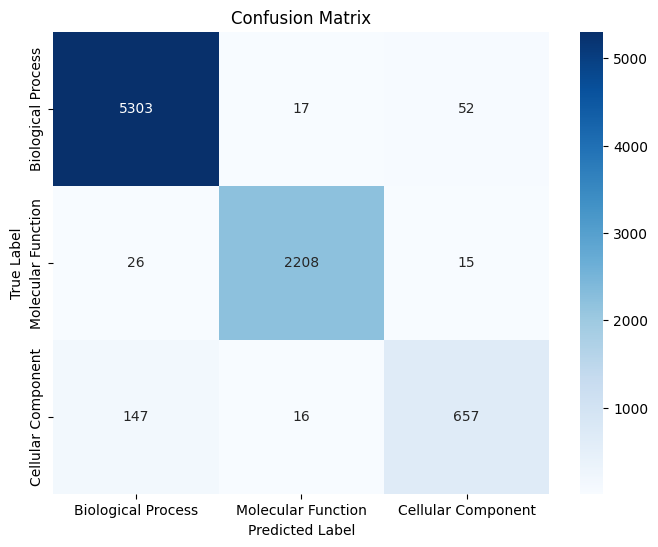

In [37]:
cm = confusion_matrix(y_test, y_pred, labels=['biological_process', 'molecular_function', 'cellular_component'])

# Plotting using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Biological Process', 'Molecular Function', 'Cellular Component'], yticklabels=['Biological Process', 'Molecular Function', 'Cellular Component'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('../images/SVM1.png')
plt.show()

#### 2. Ignoring the words that do not appear in 5% of definitions

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X5_df_downsampled, X5_downsampled_y, test_size=0.2, random_state=42)
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

In [103]:
accuracy_score(y_test, y_pred)


0.37533333333333335

In [104]:
confusion_matrix(y_test, y_pred)

array([[237,  98, 192],
       [205, 137, 139],
       [204,  99, 189]])

Optimizing using GridSearch

In [56]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
}

grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='accuracy')

In [57]:
grid_search.best_estimator_

SVC(C=10, gamma=0.1, random_state=42)

In [58]:
print(grid_search.best_params_)

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


#### Testing on full dataset 

In [108]:
y = df['namespace']
X_train, X_test, y_train, y_test = train_test_split(X5_df, y, test_size=0.2, random_state=42)
clf_svm = SVC(C=10, gamma=0.1, random_state=42)
clf_svm.fit(X_train, y_train)
y_pred = clf_svm.predict(X_test)

In [109]:
confusion_matrix(y_test, y_pred)

array([[5246,   88,   38],
       [ 292,  510,   18],
       [  77,  123, 2049]])

In [110]:
accuracy_score(y_test, y_pred)

0.9246534770761758

### Normalised Dataset

#### 1. Ignoring the words that do not appear in 1% of definitions

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X1_normalized_downsampled, X1_downsampled_y, test_size=0.2, random_state=42)
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

In [60]:
accuracy_score(y_test, y_pred)

0.412

In [61]:
confusion_matrix(y_test, y_pred)

array([[236, 131, 160],
       [175, 184, 122],
       [197,  97, 198]])

Optimizing using grid search

In [114]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
}
grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs= -1)
grid_search.fit(X_train, y_train)     

###took 180 minutes to run

GridSearchCV(cv=5, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy')

In [115]:
grid_search.best_estimator_

SVC(C=1, gamma=0.01, random_state=42)

In [116]:
print(grid_search.best_params_)

{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}


In [63]:
y = df['namespace']
X_train, X_test, y_train, y_test = train_test_split(X1_normalized, y, test_size=0.2, random_state=42)
clf_svm = SVC(C=1, gamma=0.01, random_state=42)
clf_svm.fit(X_train, y_train)
y_pred = clf_svm.predict(X_test)

In [64]:
confusion_matrix(y_test, y_pred)

array([[5315,   43,   14],
       [ 217,  597,    6],
       [  69,   12, 2168]])

In [65]:
accuracy_score(y_test, y_pred)

0.9572325553844331

#### 2. Ignoring the words that do not appear in 5% of definitions

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X5_normalized_downsampled, X5_downsampled_y, test_size=0.2, random_state=42)
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

In [67]:
accuracy_score(y_test, y_pred)

0.38333333333333336

In [68]:
confusion_matrix(y_test, y_pred)

array([[261,  97, 169],
       [214, 139, 128],
       [221,  96, 175]])

In [69]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
}

grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='accuracy')

In [70]:
grid_search.best_params_

{'C': 1, 'gamma': 0.1, 'kernel': 'poly'}

In [71]:
grid_search.best_estimator_

SVC(C=1, gamma=0.1, kernel='poly', random_state=42)

In [72]:
y = df['namespace']
X_train, X_test, y_train, y_test = train_test_split(X5_normalized, y, test_size=0.2, random_state=42)
clf_svm = SVC(C=1, gamma=0.1, kernel='poly', random_state=42)
clf_svm.fit(X_train, y_train)
y_pred = clf_svm.predict(X_test)

In [73]:
confusion_matrix(y_test, y_pred)

array([[5240,   88,   44],
       [ 297,  508,   15],
       [  79,  120, 2050]])

In [74]:
accuracy_score(y_test, y_pred)

0.9238241914465111

## Random Forests

### Non Normalised Dataset

#### 1.ignoring words not appearing in 1% defs


In [75]:
X_train, X_test, y_train, y_test = train_test_split(X1_df_downsampled,X1_downsampled_y, test_size=0.2, random_state=42)

param_distributions = {
    'n_estimators': [30,60, 100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state = 42), param_distributions, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [30, 60, 100, 200, 300]},
             scoring='accuracy')

In [78]:
grid_search.best_estimator_

RandomForestClassifier(min_samples_split=5, n_estimators=30, random_state=42)

In [79]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 30}

In [32]:
y  = df['namespace']
X_train, X_test, y_train, y_test = train_test_split(X1_df,y, test_size=0.2, random_state=42)
best_rf = RandomForestClassifier(min_samples_split=5, n_estimators=30, random_state=42)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)



In [33]:
accuracy_score(y_test, y_pred)

0.9702641867077361

#### 2.ignoring words not appearing in 5% defs


In [59]:
X_train, X_test, y_train, y_test = train_test_split(X5_df_downsampled, X5_downsampled_y, test_size=0.2, random_state=42)

In [60]:
param_distributions = {
    'n_estimators': [10, 30,60, 100, 200, 300],
    'max_depth': [10, 20, 30, 50, 10, 300, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_distributions, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, 50, 10, 300, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 30, 60, 100, 200, 300]},
             scoring='accuracy')

In [62]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=50, min_samples_leaf=4,
                       min_samples_split=10, n_estimators=30, random_state=42)

In [61]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 50,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 30}

In [63]:
y  = df['namespace']
X_train, X_test, y_train, y_test = train_test_split(X5_df,y, test_size=0.2, random_state=42)

In [64]:
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)

In [65]:
accuracy_score(y_test, y_pred)

0.9246534770761758

#### Normalised Dataset

#### 1. ignoring words not appearing in 1% defs


In [66]:
X_train, X_test, y_train, y_test = train_test_split(X1_normalized_downsampled, X1_downsampled_y, test_size=0.2, random_state=42)

In [67]:
param_distributions = {
    'n_estimators': [30,60, 100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_distributions, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train) 

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [30, 60, 100, 200, 300]},
             scoring='accuracy')

In [68]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 60}

In [69]:
y  = df['namespace']
X_train, X_test, y_train, y_test = train_test_split(X1_normalized,y, test_size=0.2, random_state=42)
best_rf = RandomForestClassifier(bootstrap=True, max_depth=None, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=60, random_state=42)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)

In [70]:
accuracy_score(y_test, y_pred)

0.968131737945741

#### 2. ignoring words not appearing in 5% defs


In [71]:
X_train, X_test, y_train, y_test = train_test_split(X5_normalized_downsampled, X5_downsampled_y, test_size=0.2, random_state=42)

In [72]:
param_distributions = {
    'n_estimators': [30,60, 100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_distributions, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [30, 60, 100, 200, 300]},
             scoring='accuracy')

In [99]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': None,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 30}

Training on full dataset

In [123]:
y  = df['namespace']
X_train, X_test, y_train, y_test = train_test_split(X5_normalized,y, test_size=0.2, random_state=42)
best_rf = RandomForestClassifier(bootstrap=False, max_depth=None, min_samples_leaf=4,
                       min_samples_split=10, n_estimators=30, random_state=42)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)

In [124]:
accuracy_score(y_test, y_pred)

0.9246534770761758